# Modeling Time Series Using ARIMA

ARIMA models are like linear regression models and are very popular in forecasting after differencing. ARIMA stands for Auto-Regressive Integrated Moving Averages. The predictors depend on the parameters (p,d,q) of the ARIMA model. Briefly, the parameters are explained as followed:

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

Rather than determining these parameters ourselves using statistical methods like the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF) plots, will use Python’s **auto.arima( )** function to find the best model parameters for us.  If a time series dataset is confirmed to have seasonality present, you must use *auto.arima( ) with “seasonality”* which requires 3 additional parameters: P, D and Q.

Let's revist the time series dataset containing the number of airline passengers traveling in a particular month.  Remember to prepare the time series data for analysis by
- converting the *Month* column to data type datetime
- setting the *Month* column as the index of the time series

In [68]:
import pandas as pd
passengers = pd.read_csv('https://mathatwork.org/DATA/airpassengers.csv')

from datetime import datetime
passengers.Month = pd.to_datetime(passengers.Month)
passengers.index = passengers.Month
passengers = passengers.drop('Month', axis=1)
print(passengers.head())

            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


Recall that decompostion revealed a clear presence of both trend and seasonality in the data which provided evidence that the data is probably non-stationary. 
<br>
Confirmed by a Dickey-Fuller test, applying first order differencing to the *passengers* data made the *passengers_first_diff* series data stationary.

In [69]:
passengers_lag1 = passengers.shift(periods=1)
passengers_first_diff = passengers - passengers_lag1
passengers_first_diff.dropna(inplace=True)

from statsmodels.tsa.stattools import adfuller

dftest = adfuller(passengers_first_diff.Passengers)
pvalue = pd.Series(dftest[1], index=['p-value'])

print(pvalue)

p-value    0.054213
dtype: float64


Since *passengers_first_diff* is confirmed stationary and *passengers* is confirmed to have seasonality present, use Python's **auto.arima( )** with seasonality to find the best ARIMA model to make our predictions regarding future airline passengers.

In [70]:
from pyramid.arima import auto_arima

best_arima_model = auto_arima(passengers, m=12, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True)
print('Best ARIMA model AIC:')
print(best_arima_model.aic())

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 1, 1, 12); AIC=1019.286, BIC=1042.287, Fit time=1.289 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1033.479, BIC=1039.229, Fit time=0.020 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1022.316, BIC=1033.817, Fit time=0.230 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1022.904, BIC=1034.405, Fit time=0.251 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=1019.088, BIC=1039.215, Fit time=0.975 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 0, 12); AIC=1018.753, BIC=1036.004, Fit time=0.462 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 0, 12); AIC=1026.100, BIC=1040.476, Fit time=0.143 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 1, 0, 12); AIC=1020.410, BIC=1040.536, Fit time=0.516 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 3) seasonal_orde

We passed into **auto.arima( )** several arguments:
- the *passengers* time series data
- **m=12** since there are 12 periods/months in each season
- **seasonal=True** since seasonality was confirmed present in the *passengers* data
- **d=1** and **D=1** since the *passengers* dataset was confirmed stationary after first order differencing
- **trace=True** to print the status of the fits to the screen
- **error_action='ignore'** and **suppress_warnings=True** to ignore errors and warnings
<br><br>
Visit [this website](http://www.alkaline-ml.com/pmdarima/0.9.0/modules/generated/pyramid.arima.auto_arima.html) for more details on **auto.arima( )** parameters.

The following parameters were returned as best for the ARIMA model:
<br>
order=(3, 1, 3) seasonal_order=(2, 1, 1, 12)
<br><br>
In addition, the best fitted ARIMA model was also returned and saved as *best_arima_model*.  Once the best ARIMA model is found, it must be trained, tested and then evaluated.  The idea is somewhat similar to what we did in the Machine Learning For Making Predictions workshop.  It is recommended that you review that workshop before proceeding.  **R Squared** will be our evaluation metric. Recall that R Squared is a measure of how well future data are likely to be predicted.
<br><br>
First import the library for the evaluation metric.

In [71]:
from sklearn.metrics import r2_score

**STEP 1: Split your data into testing and training subsets.**
<br><br>
Since this is a time series forecast, we will “chop off” a portion of our latest data and use that as the test set. Then we will train on the rest of the data.
<br><br>
Our data goes from 1949-01 to 1960-12.  Let's use 1959-01 to 1960-12 as our test data and train on the rest.

In [72]:
test = passengers.loc['1959-01':'1960-12']
train = passengers.loc['1949-01':'1958-12']

**STEP 2: Use the training data to train your model. **

In [76]:
best_arima_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(3, 1, 3),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 1, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

**STEP 3: Use the testing data to evaluate your model.**

In [77]:
arima_predict = best_arima_model.predict(n_periods=len(test))
eval_metric = r2_score(y_pred = arima_predict, y_true = test)
print(eval_metric)

0.858998147135


The **R Squared** value indicates that the model is 85.9% likely to predict the number of future airline passengers.  Let's convert the predictions to a Pandas DataFrame to print to the screen the predicted values.  Then use Pandas **.sort_index( )** to reorder the DataFrame by Month.

In [78]:
arima_predict = pd.DataFrame(arima_predict, index=test.index, columns=['Predictions'])
arima_predict.sort_index(inplace=True)
print(arima_predict)

            Predictions
Month                  
1959-01-01   354.404565
1959-02-01   331.239828
1959-03-01   382.290590
1959-04-01   378.101834
1959-05-01   389.968626
1959-06-01   467.739924
1959-07-01   531.429180
1959-08-01   538.663292
1959-09-01   441.391215
1959-10-01   395.588734
1959-11-01   339.364749
1959-12-01   371.903391
1960-01-01   390.849589
1960-02-01   359.230359
1960-03-01   416.093278
1960-04-01   411.069619
1960-05-01   420.066612
1960-06-01   507.257394
1960-07-01   573.606691
1960-08-01   578.615407
1960-09-01   477.827591
1960-10-01   428.327529
1960-11-01   366.470172
1960-12-01   404.716946


A plot of the predictions vs the actual passengers test data values can help us see how good our predictions are.  Remember to use Pandas **.sort_index( )** to reorder the test DataFrame by Month before plotting.

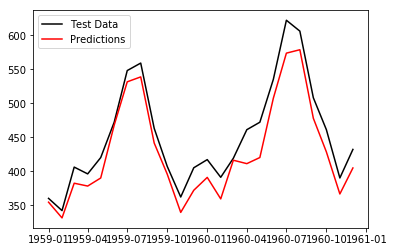

In [104]:
import matplotlib.pylab as plt

test.sort_index(inplace=True)

plt.plot(test.index, test.Passengers, color='black', label='Test Data')
plt.plot(arima_predict.index, arima_predict.Predictions, color='red', label='Predictions')
plt.legend(loc='best')
plt.show()

The average difference in test data vs predictions looks to be less than 50 passengers.  50 is relatively small. Therefore, the plot verifies what the **R Squared** value indicated regarding the model being pretty good for making predictions. Perhaps you could obtain better predictions by applying other techniques.  I will leave it up to you to find a better model as I am satisfied with the performance of this one enough to move forward with forecasting into the "real" future.  See you there!

### Exercise

Recall the time series dataset containing monthly number of sales of shampoo over a 3 year period for a UK-based online store.

In [96]:
sales = pd.read_csv('https://mathatwork.org/DATA/sales-shampoo.csv')
print(sales.head())

     Month  Sales
0  2015-01  266.0
1  2015-02  145.9
2  2015-03  183.1
3  2015-04  119.3
4  2015-05  180.3


**1)** Prepare the time series data for analysis by
- converting the *Month* column to data type datetime
- setting the *Month* column as the index of the time series

**2)** Recall that decompostion revealed a clear presence of both trend and seasonality in the data which provided evidence that the data is probably non-stationary. Furthermore, confirmed by a Dickey-Fuller test, applying first order differencing to the *passengers* data made the *passengers_first_diff* series data stationary.
<br><br>
Use Python's **auto.arima( )** with seasonality to find the best ARIMA model to make predictions regarding shampoo sales.

**3)** Split the sales data into tesing and training subsets.  The data goes from 2015-01 to 2017-12.  Use 2017-07 to 2017-12 as your test data and train on the rest.

**4)** Use the training data to train your model.

**5)** Use the testing data to evaluate your model.  In the cell below your analysis, explain how well your model predicts.

**6)** Convert your predictions to a Pandas DataFrame. Then use Pandas **.sort_index( )** to reorder the DataFrame by Month.  Print your predictions DataFrame to the screen.

**7)** Plot the predictions vs the actual sales test data values to help you see how good your predictions are. Remember to use Pandas **.sort_index( )** to reorder the test DataFrame by Month before plotting.

**8)** Does the plot verify what the R Squared indicated regarding how well future data is likely to be predicted by the model?  Explain.